##  Import Libraries

# Modeling

## Prepare the data for modeling

In [ ]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# Drop date columns and columns that we used to generate the 'misconduct' feature
df = allyrs.drop(['id', 'case_number', 'date_assigned', 'date_presented', 'ia_finding', 'crb_decision'], axis=1)

In [ ]:
df.head()

,allegation,unanimous_vote,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc,misconduct
0,ARREST,YES,CENTRAL,B,M,NO,NO,0
1,FORCE,YES,CENTRAL,B,M,NO,NO,0
2,OF1 PROCEDURE,YES,CENTRAL,B,M,NO,NO,1
3,DISCRIMINATION,YES,WESTERN,W,M,NO,NO,0
4,DISCRIMINATION,YES,WESTERN,W,M,NO,NO,0


In [ ]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df)

df_encoded.head()

,misconduct,allegation_0F4 PROCEDURE,allegation_ARREST,allegation_CONDUCT,allegation_COURTESY,allegation_CRIMINAL CONDUCT,allegation_DETENTION,allegation_DISCRIMINATION,allegation_FORCE,allegation_ICD,...,complainant_race_UNK,complainant_race_W,complainant_gender_F,complainant_gender_M,complainant_gender_UNK,changes_,changes_NO,changes_YES,crb_viewed_bwc_NO,crb_viewed_bwc_YES
0,0,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
1,0,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
2,1,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
3,0,False,False,False,False,False,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False
4,0,False,False,False,False,False,False,True,False,False,...,False,True,False,True,False,False,True,False,True,False


In [ ]:
# Split the data into training and testing sets
X = df_encoded.drop('misconduct', axis=1)
y = df_encoded['misconduct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regresstion

Imbalanced data set performance

In [ ]:
# Define hyperparameters to tune
log_reg = LogisticRegression(random_state=42)

log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_gs = GridSearchCV(log_reg, log_reg_params, cv=5)

log_reg_imb = log_reg_gs.fit(X_train, y_train)

log_reg_imb_preds = log_reg_gs.predict(X_test)

log_reg_imb_auc = roc_auc_score(y_test, log_reg_imb_preds)

print(f'Logistic Regression AUC-ROC Score: {log_reg_imb_auc}')

Logistic Regression AUC-ROC Score: 0.844551282051282


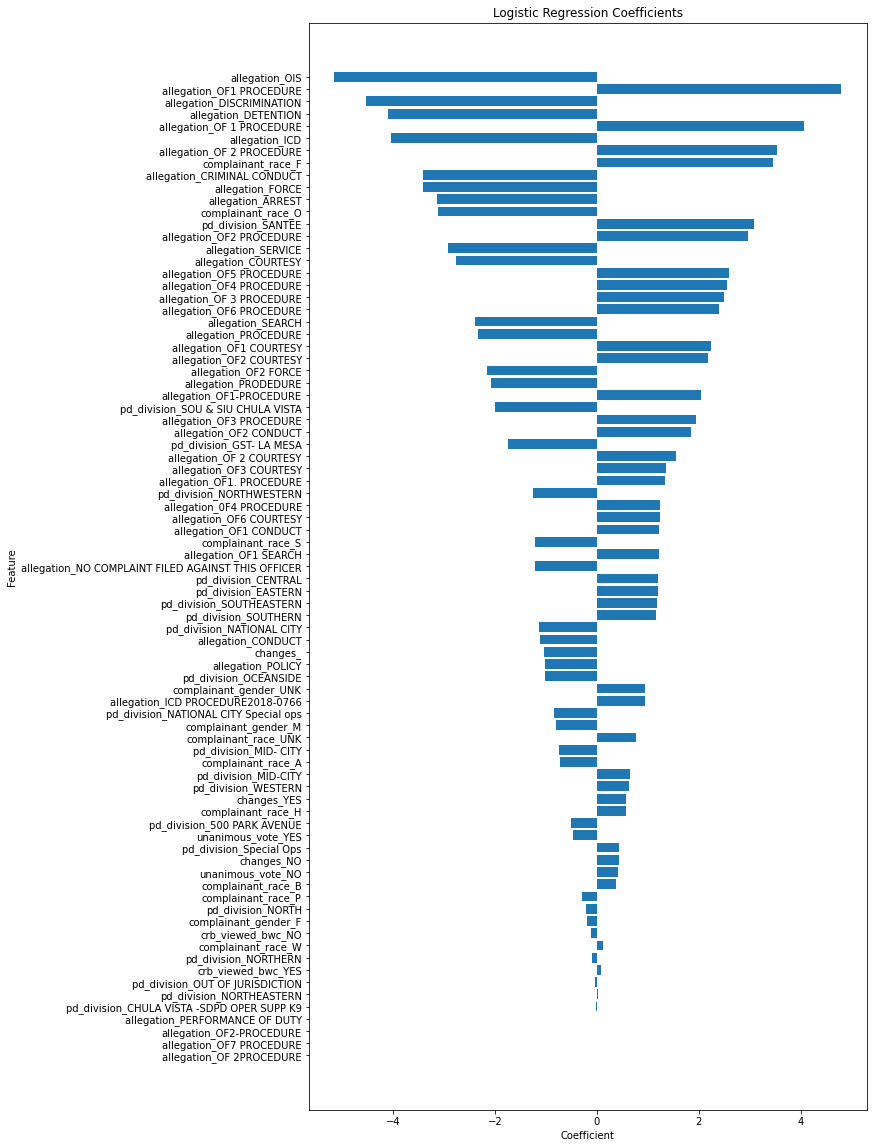

In [ ]:
# Fetch the coefficients from the trained logistic regression model
coefficients = log_reg_imb.best_estimator_.coef_[0]

# Create a dataframe for the coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Get the absolute values of the coefficients for sorting
coefficients_df['abs'] = coefficients_df['Coefficient'].apply(abs)
coefficients_df = coefficients_df.sort_values('abs', ascending=False).drop(columns='abs')

# Plot the coefficients
plt.figure(figsize=(10,20))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()


### AUC-ROC

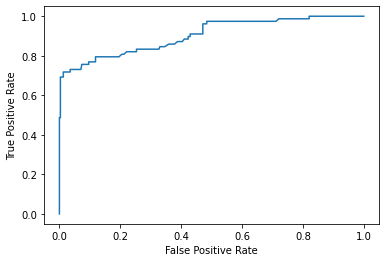

In [ ]:
#define metrics
from sklearn import metrics
y_lr_pred_proba = log_reg_gs.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_lr_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced dataset

In [ ]:
!pip install imblearn

In [ ]:
#rebalance the dataset using imblearn
from imblearn.over_sampling import RandomOverSampler

# Define the random oversampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the transform
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Check the balance of the target variable
y_train_bal.value_counts()

misconduct
0    1248
1    1248
Name: count, dtype: int64

In [ ]:
#train balanced model
log_reg_bal = log_reg_gs.fit(X_train_bal, y_train_bal)

log_reg_bal_preds = log_reg_bal.predict(X_test)

log_reg_bal_auc = roc_auc_score(y_test, log_reg_bal_preds)

print(f'Logistic Regression AUC-ROC Score: {log_reg_bal_auc}')

Logistic Regression AUC-ROC Score: 0.8477564102564102


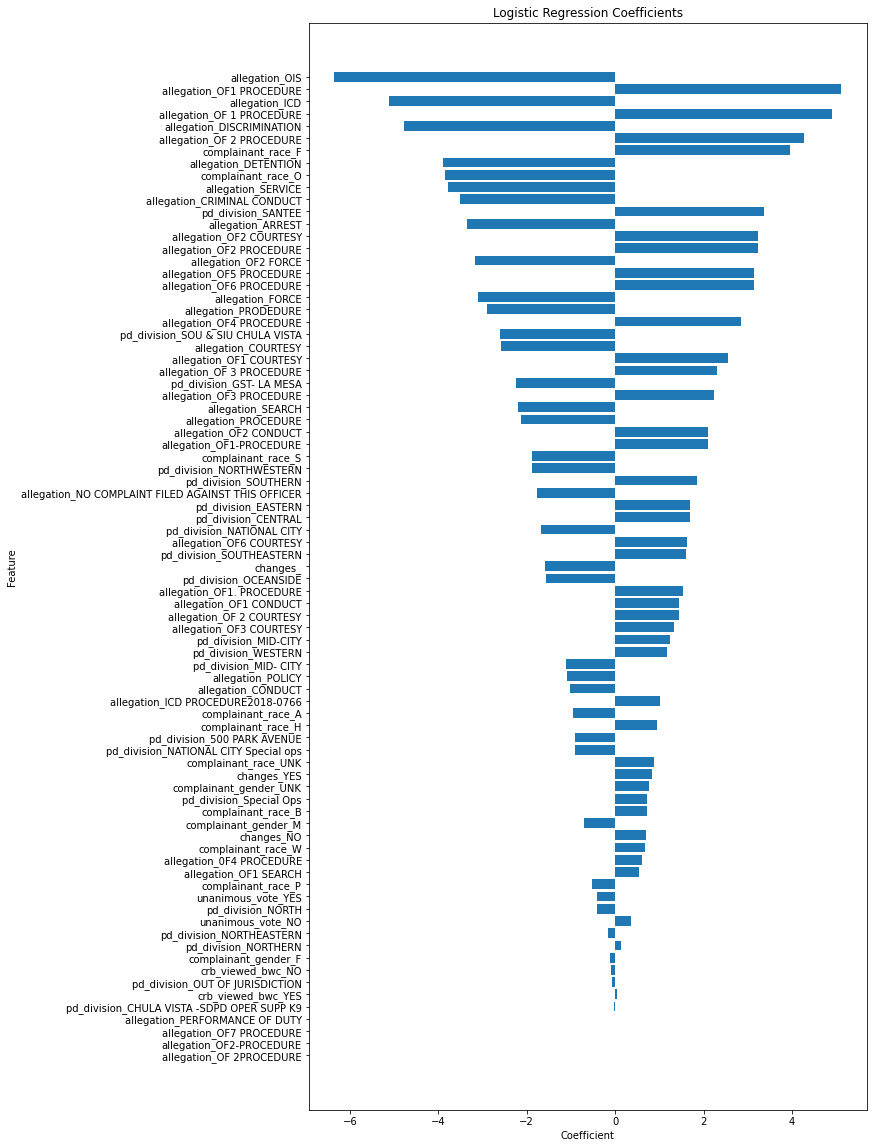

In [ ]:
# Fetch the coefficients from the trained logistic regression model
coefficients = log_reg_bal.best_estimator_.coef_[0]

# Create a dataframe for the coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Get the absolute values of the coefficients for sorting
coefficients_df['abs'] = coefficients_df['Coefficient'].apply(abs)
coefficients_df = coefficients_df.sort_values('abs', ascending=False).drop(columns='abs')

# Plot the coefficients
plt.figure(figsize=(10,20))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

### AUC-ROC

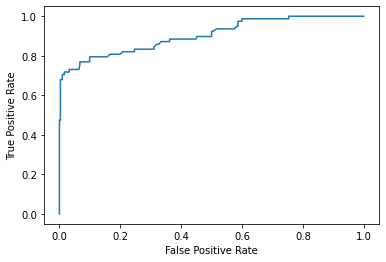

In [ ]:
#define metrics
from sklearn import metrics
y_lr_bal_pred_proba = log_reg_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_lr_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Penalized Logistic Regression

### Imbalanced

In [ ]:
#Grid search was implemented to identify the ideal values for a model’s hyperparameters. 
#Set a grid of parameters to map estimator parameters to sequences of allowed values
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']

In [ ]:

lr_pen_imb = LogisticRegression(penalty='l2', C=best_C)
lr_pen_imb.fit(X_train, y_train)

LogisticRegression(C=10)

In [ ]:
lr_pen_imb_pred = lr_pen_imb.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import statistics as stats
from sklearn.model_selection import cross_val_score
accuracy = accuracy_score(y_test, lr_pen_imb_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, lr_pen_imb_pred))
print("Cross Val Score: ", stats.mean(cross_val_score(lr_pen_imb, X_train, 
                                                      y_train, cv = 5)))

Accuracy: 0.9358974358974359
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       312
           1       0.98      0.69      0.81        78

    accuracy                           0.94       390
   macro avg       0.96      0.84      0.89       390
weighted avg       0.94      0.94      0.93       390

Cross Val Score:  0.9280608459065051


### AUC-ROC

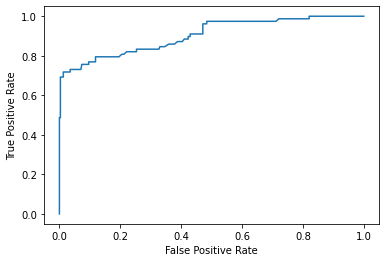

In [ ]:
#define metrics
from sklearn import metrics
lr_pen_imb_pred_proba = lr_pen_imb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  lr_pen_imb_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train_bal, y_train_bal)

best_C = grid_search.best_params_['C']

In [ ]:
lr_pen_bal = LogisticRegression(penalty='l2', C=best_C)
lr_pen_bal.fit(X_train_bal, y_train_bal)

LogisticRegression(C=10)

In [ ]:
lr_pen_bal_pred = lr_pen_bal.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
import statistics as stats
from sklearn.model_selection import cross_val_score
accuracy = accuracy_score(y_test, lr_pen_bal_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, lr_pen_bal_pred))
print("Cross Val Score: ", stats.mean(cross_val_score(lr_pen_bal, X_train_bal, 
                                                      y_train_bal, cv = 5)))

Accuracy: 0.8948717948717949
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       312
           1       0.72      0.77      0.75        78

    accuracy                           0.89       390
   macro avg       0.83      0.85      0.84       390
weighted avg       0.90      0.89      0.90       390

Cross Val Score:  0.8381394789579159


### AUC-ROC

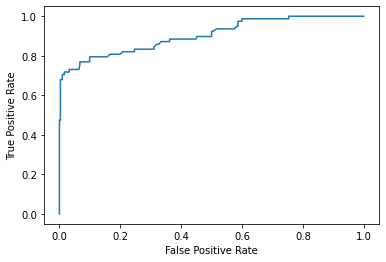

In [ ]:
#define metrics
from sklearn import metrics
lr_pen_bal_pred_proba = lr_pen_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  lr_pen_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

### Imbalanced

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_imb= RandomForestClassifier(n_estimators=50)
rf_imb.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
rf_imb.score(X_test, y_test)

0.9153846153846154

In [ ]:
rf_imb_pred = rf_imb.predict(X_test)

print(classification_report(y_test, rf_imb_pred))

print("Cross Val Score: ", stats.mean(cross_val_score(rf_imb, X_train, y_train, cv = 5)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       312
           1       0.88      0.67      0.76        78

    accuracy                           0.92       390
   macro avg       0.90      0.82      0.85       390
weighted avg       0.91      0.92      0.91       390

Cross Val Score:  0.9261315854563443


### AUC-ROC

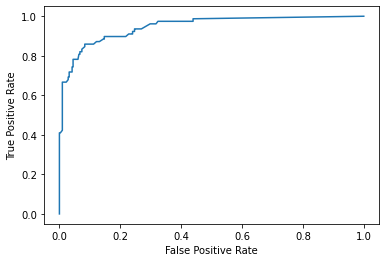

In [ ]:
#define metrics
from sklearn import metrics
rf_imb_pred_proba = rf_imb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  rf_imb_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_bal = RandomForestClassifier(n_estimators=50)
rf_bal.fit(X_train_bal, y_train_bal)

RandomForestClassifier(n_estimators=50)

In [ ]:
rf_bal.score(X_test, y_test)

0.8871794871794871

In [ ]:
rf_bal_pred = rf_bal.predict(X_test)

print(classification_report(y_test, rf_bal_pred))

print("Cross Val Score: ", stats.mean(cross_val_score(rf_bal, X_train_bal, y_train_bal, cv = 5)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       312
           1       0.67      0.85      0.75        78

    accuracy                           0.89       390
   macro avg       0.82      0.87      0.84       390
weighted avg       0.90      0.89      0.89       390

Cross Val Score:  0.938304609218437


### AUC-ROC

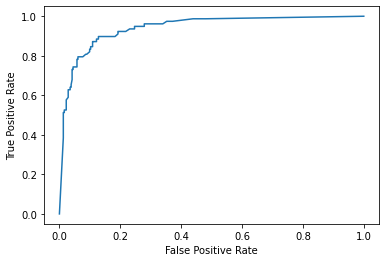

In [ ]:
#define metrics
from sklearn import metrics
rf_bal_pred_proba = rf_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  rf_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Decision Tree

### Imbalanced

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_imb = DecisionTreeClassifier().fit(X_train, y_train)
dt_imb_pred = dt_imb.predict(X_test)

print(classification_report(y_test, dt_imb_pred))
print("Cross Val Score: ", stats.mean(cross_val_score(dt_imb, X_train, 
                                                      y_train, cv = 5))) 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       312
           1       0.87      0.68      0.76        78

    accuracy                           0.92       390
   macro avg       0.90      0.83      0.86       390
weighted avg       0.91      0.92      0.91       390

Cross Val Score:  0.9222792480831066


### AUC-ROC

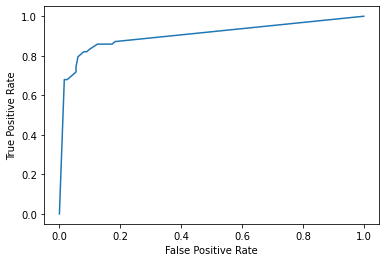

In [ ]:
#define metrics
from sklearn import metrics
dt_imb_pred_proba = dt_imb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  dt_imb_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_bal = DecisionTreeClassifier().fit(X_train_bal, y_train_bal)
dt_bal_pred = dt_bal.predict(X_test)

print(classification_report(y_test, dt_bal_pred))
print("Cross Val Score: ", stats.mean(cross_val_score(dt_bal, X_train_bal, 
                                                      y_train_bal, cv = 5))) 

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       312
           1       0.65      0.86      0.74        78

    accuracy                           0.88       390
   macro avg       0.81      0.87      0.83       390
weighted avg       0.90      0.88      0.89       390

Cross Val Score:  0.9274901803607215


### AUC-ROC

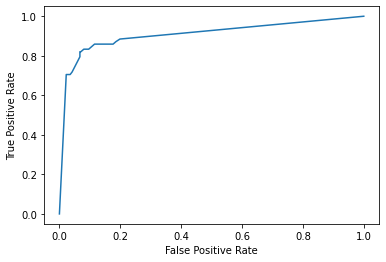

In [ ]:
#define metrics
from sklearn import metrics
dt_bal_pred_proba = dt_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  dt_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

### Imbalanced

In [ ]:
from sklearn import svm

SVM_imb = svm.SVC(kernel='linear', gamma='auto', C=2, probability=True)
SVM_imb.fit(X_train, y_train)

SVM_imb_predict = SVM_imb.predict(X_test)

In [ ]:
print(classification_report(y_test, SVM_imb_predict))
print("Cross Val Score: ", stats.mean(cross_val_score(SVM_imb, X_train, 
                                                      y_train, cv = 5))) 

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       312
           1       0.96      0.65      0.78        78

    accuracy                           0.93       390
   macro avg       0.94      0.82      0.87       390
weighted avg       0.93      0.93      0.92       390

Cross Val Score:  0.924849534174293


### AUC-ROC

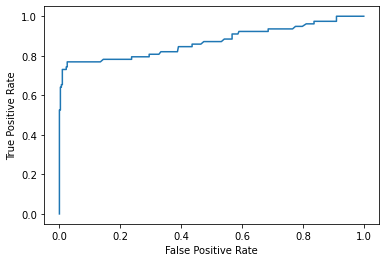

In [ ]:
#define metrics
from sklearn import metrics
SVM_imb_pred_proba = SVM_imb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  SVM_imb_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced

In [ ]:
from sklearn import svm

SVM_bal = svm.SVC(kernel='linear', gamma='auto', C=2, probability=True)
SVM_bal.fit(X_train_bal, y_train_bal)

SVM_bal_predict = SVM_bal.predict(X_test)

In [ ]:
print(classification_report(y_test, SVM_bal_predict))
print("Cross Val Score: ", stats.mean(cross_val_score(SVM_bal, X_train_bal, 
                                                      y_train_bal, cv = 5))) 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       312
           1       0.89      0.71      0.79        78

    accuracy                           0.92       390
   macro avg       0.91      0.84      0.87       390
weighted avg       0.92      0.92      0.92       390

Cross Val Score:  0.8261202404809619


### AUC-ROC

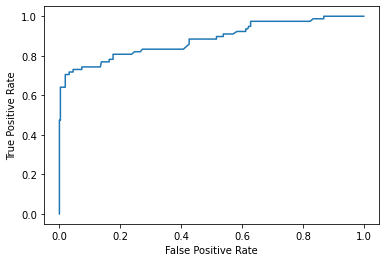

In [ ]:
#define metrics
from sklearn import metrics
SVM_bal_pred_proba = SVM_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  SVM_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## K-Nearest-Neighbors

### Imbalanced

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
kneighbors_imb = KNeighborsClassifier().fit(X_train, y_train)
knn_imb_pred = kneighbors_imb.predict(X_test)

print(classification_report(y_test, knn_imb_pred))

print("Cross Val Score: ", stats.mean(cross_val_score(kneighbors_imb, 
                                                      X_train, y_train, cv=5)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       312
           1       0.79      0.42      0.55        78

    accuracy                           0.86       390
   macro avg       0.83      0.70      0.73       390
weighted avg       0.85      0.86      0.84       390

Cross Val Score:  0.8503586445708632


### AUC-ROC

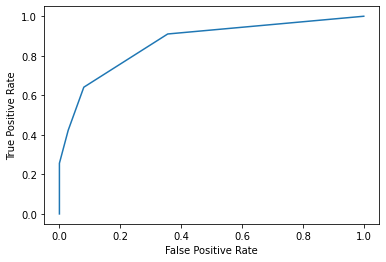

In [ ]:
#define metrics
from sklearn import metrics
knn_imb_pred_proba = kneighbors_imb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_imb_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Balanced

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
kneighbors_bal = KNeighborsClassifier().fit(X_train_bal, y_train_bal)
knn_bal_pred = kneighbors_bal.predict(X_test)

print(classification_report(y_test, knn_bal_pred))

print("Cross Val Score: ", stats.mean(cross_val_score(kneighbors_bal, 
                                                      X_train_bal, y_train_bal, cv=5)))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       312
           1       0.55      0.74      0.63        78

    accuracy                           0.83       390
   macro avg       0.74      0.79      0.76       390
weighted avg       0.85      0.83      0.83       390

Cross Val Score:  0.8709963927855712


### AUC-ROC

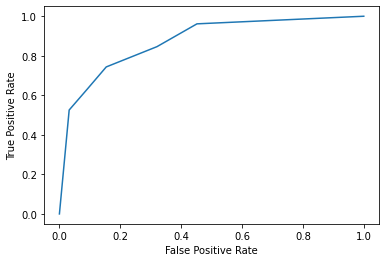

In [ ]:
#define metrics
from sklearn import metrics
knn_bal_pred_proba = kneighbors_bal.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_bal_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Composite AUC-ROC

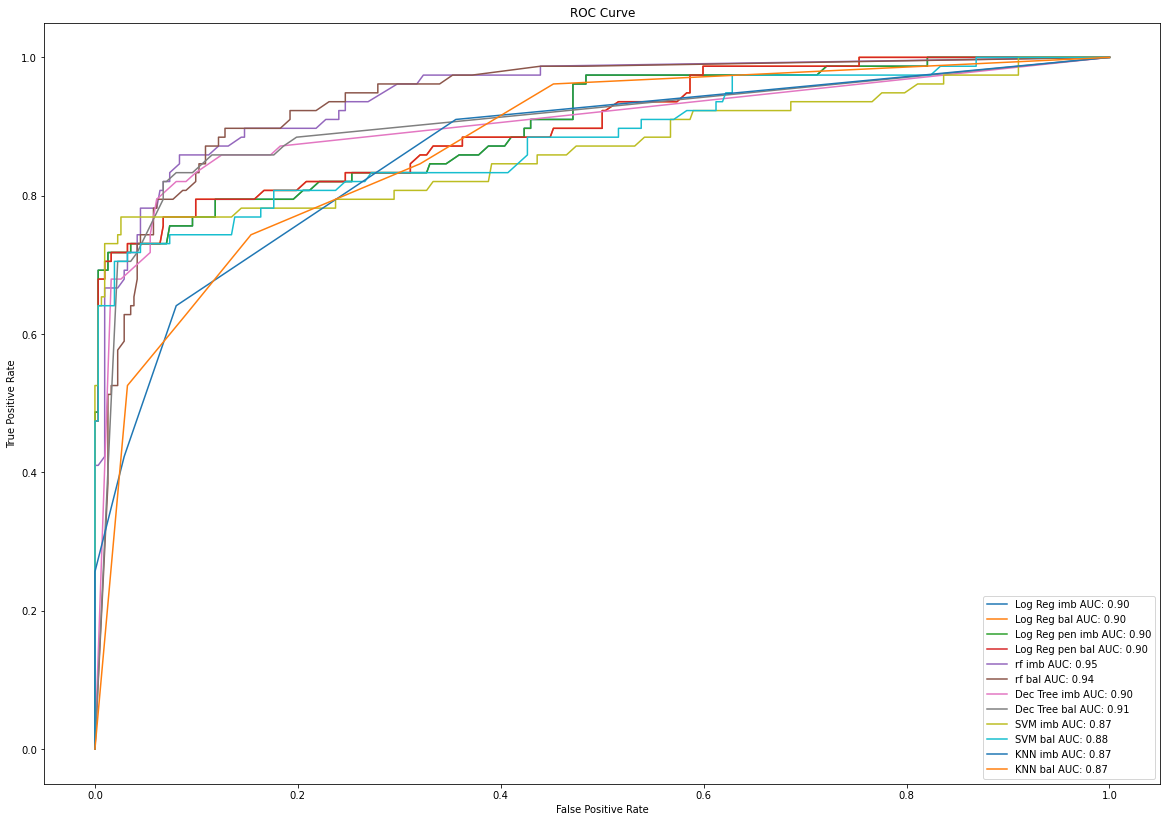

In [ ]:
# Get the AUC-ROC score for each model to plot
lr_imb_auc = metrics.roc_auc_score(y_test, y_lr_pred_proba)
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_lr_pred_proba)
lr_bal_auc = metrics.roc_auc_score(y_test, y_lr_bal_pred_proba)
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_lr_bal_pred_proba)

lr_pen_imb_auc = metrics.roc_auc_score(y_test, lr_pen_imb_pred_proba)
fpr3, tpr3, _ = metrics.roc_curve(y_test, lr_pen_imb_pred_proba)
lr_pen_bal_auc = metrics.roc_auc_score(y_test, lr_pen_bal_pred_proba)
fpr4, tpr4, _ = metrics.roc_curve(y_test,  lr_pen_bal_pred_proba)

rf_imb_auc = metrics.roc_auc_score(y_test, rf_imb_pred_proba)
fpr5, tpr5, _ = metrics.roc_curve(y_test,  rf_imb_pred_proba)
rf_bal_auc = metrics.roc_auc_score(y_test, rf_bal_pred_proba)
fpr6, tpr6, _ = metrics.roc_curve(y_test,  rf_bal_pred_proba)

dt_imb_auc = metrics.roc_auc_score(y_test, dt_imb_pred_proba)
fpr7, tpr7, _ = metrics.roc_curve(y_test,  dt_imb_pred_proba)
dt_bal_auc = metrics.roc_auc_score(y_test, dt_bal_pred_proba)
fpr8, tpr8, _ = metrics.roc_curve(y_test,  dt_bal_pred_proba)

SVM_imb_auc = metrics.roc_auc_score(y_test, SVM_imb_pred_proba)
fpr9, tpr9, _ = metrics.roc_curve(y_test,  SVM_imb_pred_proba)
SVM_bal_auc = metrics.roc_auc_score(y_test, SVM_bal_pred_proba)
fpr10, tpr10, _ = metrics.roc_curve(y_test,  SVM_bal_pred_proba)

knn_imb_auc = metrics.roc_auc_score(y_test, knn_imb_pred_proba)
fpr11, tpr11, _ = metrics.roc_curve(y_test,  knn_imb_pred_proba)
knn_bal_auc = metrics.roc_auc_score(y_test, knn_bal_pred_proba)
fpr12, tpr12, _ = metrics.roc_curve(y_test,  knn_bal_pred_proba)


# Plot the ROC curve
plt.figure(figsize=(20, 14))
plt.plot(fpr1, tpr1, label=f'Log Reg imb AUC: {lr_imb_auc:.2f}')
plt.plot(fpr2, tpr2, label=f'Log Reg bal AUC: {lr_bal_auc:.2f}')
plt.plot(fpr3, tpr3, label=f'Log Reg pen imb AUC: {lr_pen_imb_auc:.2f}')
plt.plot(fpr4, tpr4, label=f'Log Reg pen bal AUC: {lr_pen_bal_auc:.2f}')
plt.plot(fpr5, tpr5, label=f'rf imb AUC: {rf_imb_auc:.2f}')
plt.plot(fpr6, tpr6, label=f'rf bal AUC: {rf_bal_auc:.2f}')
plt.plot(fpr7, tpr7, label=f'Dec Tree imb AUC: {dt_imb_auc:.2f}')
plt.plot(fpr8, tpr8, label=f'Dec Tree bal AUC: {dt_bal_auc:.2f}')
plt.plot(fpr9, tpr9, label=f'SVM imb AUC: {SVM_imb_auc:.2f}')
plt.plot(fpr10, tpr10, label=f'SVM bal AUC: {SVM_bal_auc:.2f}')
plt.plot(fpr11, tpr11, label=f'KNN imb AUC: {knn_imb_auc:.2f}')
plt.plot(fpr12, tpr12, label=f'KNN bal AUC: {knn_bal_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()